## Simple baseline with Bioclimatic Cubes — ResNet18 + Binary Cross Entropy

To demonstrate the potential of single modality data such as Bioclimatic cubes,
we provide a straightforward baseline that is baseline on a modified ResNet18
and Binary Cross Entropy but still ranks highly on the leaderboard. The model
itself should learn the relationship between the precise climatic history of a
given location and its species composition.

Considering the significant extent for enhancing performance of this baseline,
we encourage you to experiment with various techniques, architectures, losses,
etc.

#### **Have Fun!**

In [1]:
import os
import torch
import tqdm
import numpy as np
import pandas as pd
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_recall_fscore_support

## Data description

The Bioclimatic Cubes are created from **four** monthly GeoTIFF CHELSA
(https://chelsa-climate.org/timeseries/) time series climatic rasters with a
resolution of 30 arc seconds, i.e. approximately 1km. The four variables are the
precipitation (pr), maximum- (taxmax), minimum- (tasmin), and mean (tax) daily
temperatures per month from January 2000 to June 2019.

We provide the data in three forms:

(i) raw rasters (GeoTiff images),

(ii) CSV file with pre-extracted values for each location, i.e., surveyId, and

(iii) data cubes as tensor object (.pt).

In this notebook, we will work with just the cubes. The cubes are structured as
follows. **Shape**: `(n_year, n_month, n_bio)` where:

- `n_year` = 19 (ranging from 2000 to 2018)
- `n_month` = 12 (ranging from January 01 to December 12)
- `n_bio` = 4 comprising [`pr` (precipitation), `tas` (mean daily air
  temperature), `tasmin`, `tasmax`]

The datacubes can simply be loaded as tensors using PyTorch with the following
command :

```python
import torch
torch.load('path_to_file.pt')
```

**References:**

- _Karger, D.N., Conrad, O., Böhner, J., Kawohl, T., Kreft, H., Soria-Auza,
  R.W., Zimmermann, N.E., Linder, P., Kessler, M. (2017): Climatologies at high
  resolution for the Earth land surface areas. Scientific Data. 4 170122.
  https://doi.org/10.1038/sdata.2017.122_

- _Karger D.N., Conrad, O., Böhner, J., Kawohl, T., Kreft, H., Soria-Auza, R.W.,
  Zimmermann, N.E, Linder, H.P., Kessler, M. Data from: Climatologies at high
  resolution for the earth’s land surface areas. Dryad Digital Repository.
  http://dx.doi.org/doi:10.5061/dryad.kd1d4_

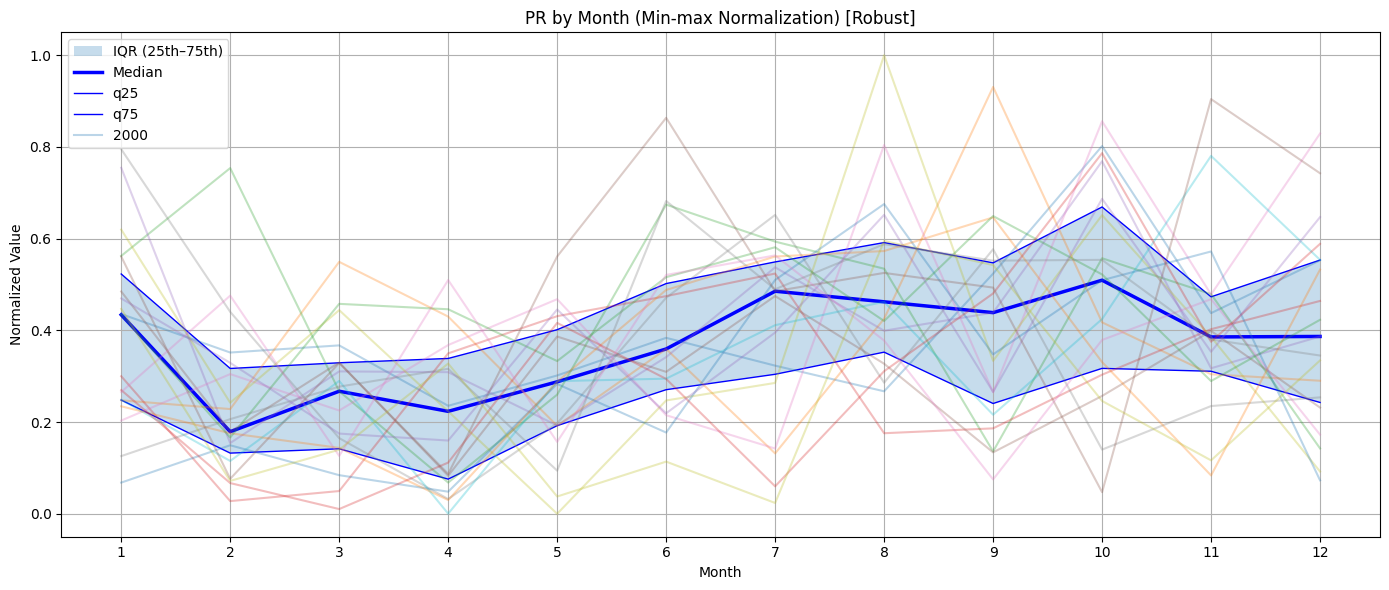

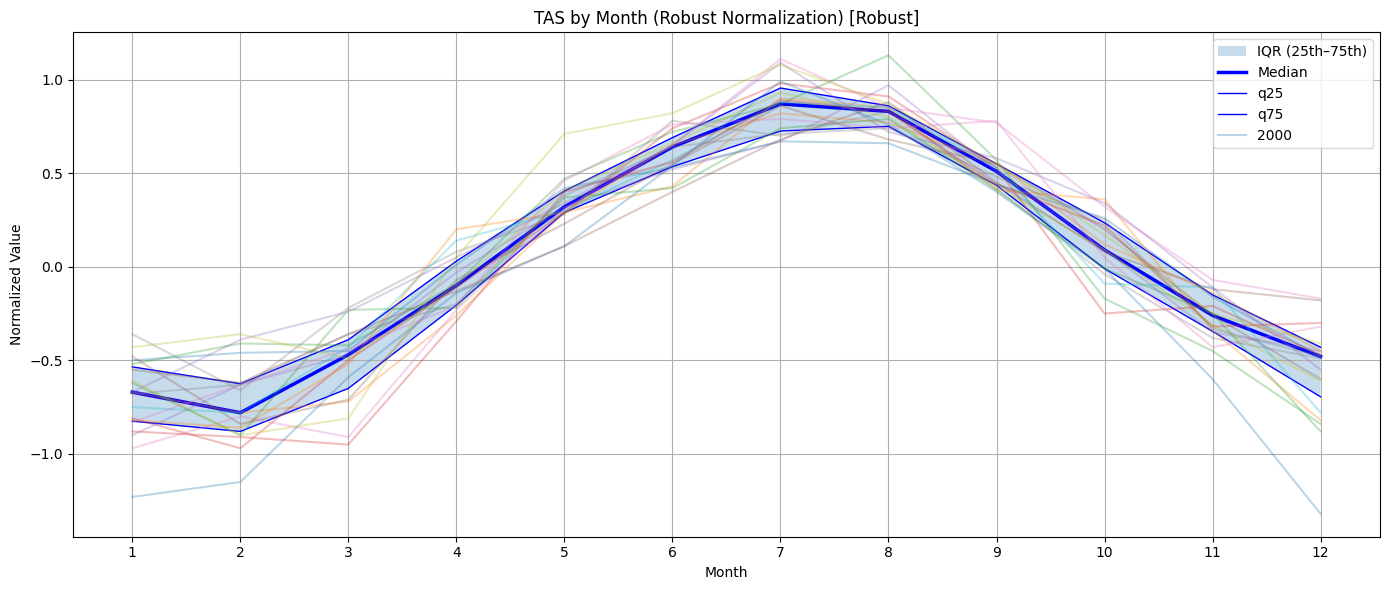

In [2]:
from pickle import TRUE
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable, Dict, Tuple

# Constants
BIO_VARS = ["pr", "tas", "tasmin", "tasmax"]
YEARS = list(range(2000, 2019))
MONTHS = list(range(1, 13))

# ----------------- Core Pure Functions -----------------


def load_cube(path: str) -> np.ndarray:
    """Load PyTorch tensor and convert to NumPy array."""
    return torch.load(path).numpy()


def normalize_cube(cube: np.ndarray) -> np.ndarray:
    """Normalize each bioclimatic variable independently over time."""

    # shape: (n_year, n_month, n_bio)
    def normalize(var_data: np.ndarray) -> np.ndarray:
        flat = var_data.flatten()
        mean, std = flat.mean(), flat.std()
        return (var_data - mean) / std

    return np.stack([normalize(cube[..., i]) for i in range(cube.shape[2])], axis=-1)


def aggregate_monthly_mean(cube: np.ndarray) -> np.ndarray:
    """Average across years to get monthly trends per variable."""
    return cube.mean(axis=0)  # shape: (12, 4)


def aggregate_yearly_mean(cube: np.ndarray) -> np.ndarray:
    """Average across months to get yearly trends per variable."""
    return cube.mean(axis=1)  # shape: (n_years, 4)


# ----------------- Visualization -----------------


def plot_monthly_means(monthly_mean: np.ndarray):
    months = [f"{m:02d}" for m in MONTHS]
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(BIO_VARS):
        plt.plot(months, monthly_mean[:, i], label=label)
    plt.title("Monthly Mean Trends (Normalized)")
    plt.xlabel("Month")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_yearly_means(yearly_mean: np.ndarray):
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(BIO_VARS):
        plt.plot(YEARS, yearly_mean[:, i], label=label)
    plt.title("Yearly Mean Trends (Normalized)")
    plt.xlabel("Year")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ----------------- Pipeline -----------------


def process_and_visualize(cube_path: str):
    cube = load_cube(cube_path)
    norm_cube = normalize_cube(cube)
    monthly = aggregate_monthly_mean(norm_cube)
    yearly = aggregate_yearly_mean(norm_cube)
    plot_monthly_means(monthly)
    plot_yearly_means(yearly)


def plot_bioclim_variable_by_month(cube: np.ndarray, var_name: str):
    """
    Plots monthly time series of a given bioclimatic variable (e.g. 'pr', 'tas') across years.

    Parameters:
    - cube: np.ndarray of shape (n_year, n_month, n_bio)
    - var_name: one of 'pr', 'tas', 'tasmin', 'tasmax'
    """
    if var_name not in BIO_VARS:
        raise ValueError(f"Invalid var_name: {var_name}. Must be one of {BIO_VARS}")

    var_index = BIO_VARS.index(var_name)
    var_cube = cube[..., var_index]  # shape: (n_year, n_month)

    # Transpose if shape is (12, 19)
    if var_cube.shape != (len(YEARS), len(MONTHS)):
        var_cube = var_cube.T

    mean_monthly_values = var_cube.mean(axis=0)
    months = [f"{m:02d}" for m in MONTHS]

    plt.figure(figsize=(14, 6))

    for year_idx, year in enumerate(YEARS):
        plt.plot(
            months,
            var_cube[year_idx],
            alpha=0.4,
            label=str(year) if year_idx == 0 else "",
        )

    plt.plot(
        months,
        mean_monthly_values,
        color="black",
        linewidth=2.5,
        label=f"Mean (2000–2018)",
    )

    plt.title(f"Monthly '{var_name}' per Year with Mean Overlay")
    plt.xlabel("Month")
    plt.ylabel(f"{var_name} (units)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def load_and_fix_cube(path: str) -> np.ndarray:
    """
    Loads a .pt cube and ensures it's ordered as (n_year, n_month, n_bio).
    """
    cube = torch.load(path).numpy()
    if cube.shape == (4, 19, 12):
        cube = np.transpose(cube, (1, 2, 0))  # (bio, year, month) → (year, month, bio)
    return cube


cube = load_and_fix_cube(
    path="../geolifeclef-2025/BioclimTimeSeries/cubes/PA-train/GLC25-PA-train-bioclimatic_monthly_3917344_cube.pt"
)

# for var in BIO_VARS:
#     plot_bioclim_variable_by_month(cube=cube, var_name=var)


# def plot_combined_temperature_means(cube: np.ndarray):
#     """
#     Plots the average monthly tasmin, tas, and tasmax across all years.
#     Useful for comparing temperature ranges and seasonal patterns.
#     """
#     # Extract and validate all temperature layers
#     indices = {var: BIO_VARS.index(var) for var in ["tasmin", "tas", "tasmax"]}
#     tasmin_cube = cube[..., indices["tasmin"]]
#     tas_cube = cube[..., indices["tas"]]
#     tasmax_cube = cube[..., indices["tasmax"]]

#     # Transpose if needed
#     def fix_shape(arr):
#         return arr.T if arr.shape != (len(YEARS), len(MONTHS)) else arr

#     tasmin_cube = fix_shape(tasmin_cube)
#     tas_cube = fix_shape(tas_cube)
#     tasmax_cube = fix_shape(tasmax_cube)

#     # Compute average over years
#     mean_tasmin = tasmin_cube.mean(axis=0)
#     mean_tas = tas_cube.mean(axis=0)
#     mean_tasmax = tasmax_cube.mean(axis=0)
#     months = [f"{m:02d}" for m in MONTHS]

#     # Plot
#     plt.figure(figsize=(14, 6))
#     plt.plot(months, mean_tasmin, label="Mean tasmin", color="blue")
#     plt.plot(months, mean_tas, label="Mean tas", color="black")
#     plt.plot(months, mean_tasmax, label="Mean tasmax", color="red")

#     plt.title("Average Monthly Temperatures: tasmin, tas, tasmax (2000–2018)")
#     plt.xlabel("Month")
#     plt.ylabel("Temperature (°C)")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# plot_combined_temperature_means(cube)


def log_transform_variable(cube: np.ndarray, var_index: int) -> np.ndarray:
    """
    Applies log(1 + x) transform to the selected variable over (year, month).
    Safe for strictly non-negative values (e.g., precipitation).
    """
    data = cube[..., var_index]
    return np.log1p(data)


def min_max_scale_variable(cube: np.ndarray, var_index: int) -> np.ndarray:
    """
    Min-max scales the selected variable over (year, month).
    Returns data in [0, 1].
    """
    data = cube[..., var_index]
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val) if max_val > min_val else data * 0


def robust_scale_variable(cube: np.ndarray, var_index: int) -> np.ndarray:
    """
    Applies robust scaling (subtract median, divide by IQR) to reduce effect of outliers.
    """
    data = cube[..., var_index]
    median = np.median(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return (data - median) / iqr if iqr > 0 else data * 0


# Mapping from method name to normalization function generator
NORMALIZATION_FUNCS: Dict[str, Callable[[np.ndarray, int], np.ndarray]] = {
    "log": log_transform_variable,
    "min-max": min_max_scale_variable,
    "robust": robust_scale_variable,
}


def plot_normalized_bioclim_by_month(
    cube: np.ndarray,
    var_name: str,
    method: str = "min-max",
    show_robust: bool = True,
):
    """
    Normalize and plot a bioclimatic variable by month using the chosen method.
    Supports optional robust visualization (median + IQR).
    """
    if var_name not in BIO_VARS:
        raise ValueError(f"Unknown variable: {var_name}")
    if method not in NORMALIZATION_FUNCS:
        raise ValueError(f"Unknown normalization method: {method}")

    var_index = BIO_VARS.index(var_name)
    normalize_fn = NORMALIZATION_FUNCS[method]
    normalized_data = normalize_fn(cube, var_index)  # shape: (year, month)
    months = np.arange(1, 13)

    plt.figure(figsize=(14, 6))

    # Optional: robust visualization (median + IQR)
    if show_robust:
        median = np.median(normalized_data, axis=0)
        q25 = np.percentile(normalized_data, 25, axis=0)
        q75 = np.percentile(normalized_data, 75, axis=0)

        plt.fill_between(months, q25, q75, alpha=0.25, label="IQR (25th–75th)")

        plt.plot(months, median, color="blue", linewidth=2.5, label="Median")
        plt.plot(months, q25, color="blue", linewidth=1, label="q25")
        plt.plot(months, q75, color="blue", linewidth=1, label="q75")
    else:
        # Default mean overlay
        monthly_mean = np.mean(normalized_data, axis=0)
        plt.plot(months, monthly_mean, color="black", linewidth=2.5, label="Mean")

    # Plot each year's data as light background
    for year_idx, year in enumerate(YEARS):
        plt.plot(
            months,
            normalized_data[year_idx],
            alpha=0.3,
            label=str(year) if year_idx == 0 else "",
        )

    plt.title(
        f"{var_name.upper()} by Month ({method.capitalize()} Normalization)"
        + (" [Robust]" if show_robust else "")
    )
    plt.xlabel("Month")
    plt.ylabel("Normalized Value")
    plt.xticks(months)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_normalized_bioclim_by_month(cube, "pr", method="min-max", show_robust=True)

plot_normalized_bioclim_by_month(
    cube, var_name="tas", method="robust", show_robust=TRUE
)

# plot_normalized_bioclim_by_month(cube, var_name="tasmin", method="robust")

# plot_normalized_bioclim_by_month(cube, var_name="tasmax", method="robust")

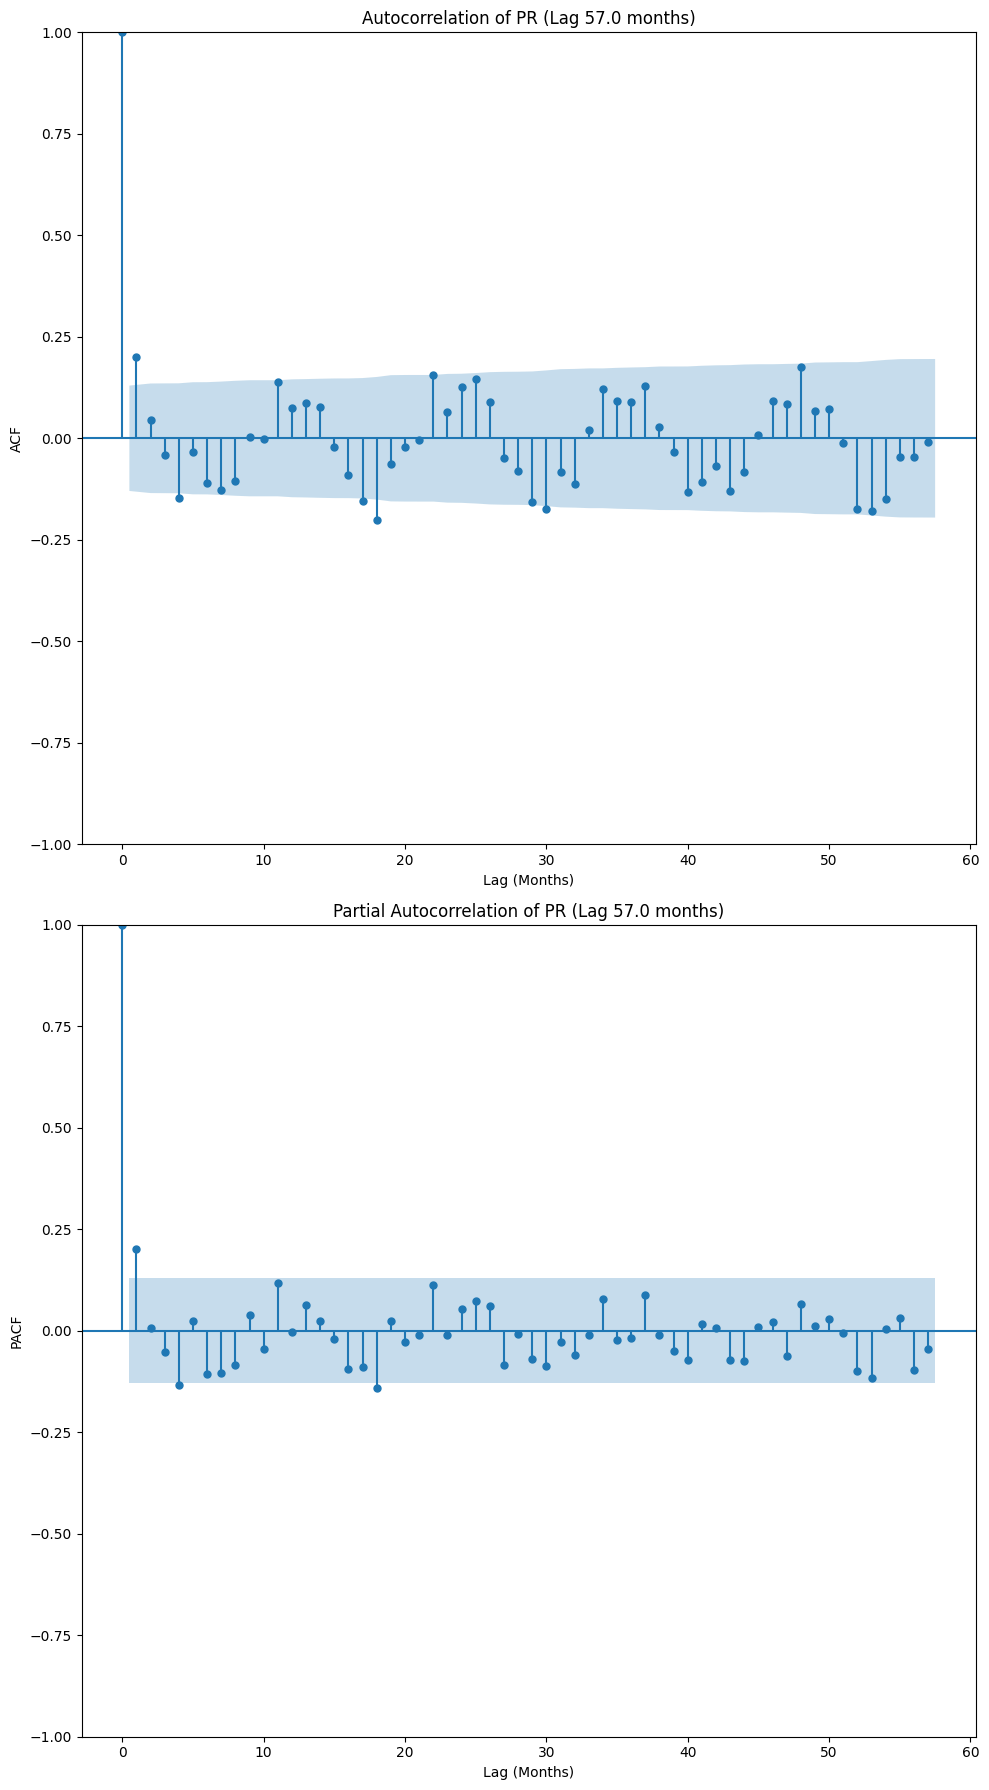

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def plot_acf_pacf_for_bioclim(cube: np.ndarray, var_name: str, max_lag: int = 12):
    """
    Plot both the Autocorrelation (ACF) and Partial Autocorrelation (PACF) for the given bioclimatic variable.
    """
    if var_name not in BIO_VARS:
        raise ValueError(f"Unknown variable: {var_name}")

    var_index = BIO_VARS.index(var_name)
    data = cube[:, :, var_index]  # Shape: (n_years, n_months)

    # Flatten the data to make it a 1D time series across months (for all years)
    flattened_data = data.flatten()

    # Create subplots for ACF and PACF
    fig, axs = plt.subplots(2, 1, figsize=(10, 18))

    # Plot ACF
    plot_acf(flattened_data, lags=max_lag, alpha=0.05, ax=axs[0])
    axs[0].set_title(f"Autocorrelation of {var_name.upper()} (Lag {max_lag} months)")
    axs[0].set_xlabel("Lag (Months)")
    axs[0].set_ylabel("ACF")

    # Plot PACF
    plot_pacf(flattened_data, lags=max_lag, alpha=0.05, ax=axs[1])
    axs[1].set_title(
        f"Partial Autocorrelation of {var_name.upper()} (Lag {max_lag} months)"
    )
    axs[1].set_xlabel("Lag (Months)")
    axs[1].set_ylabel("PACF")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


plot_acf_pacf_for_bioclim(
    cube=cube, var_name="pr", max_lag=114 / 2
)  # ACF plot for Precipitation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


def plot_spectral_analysis_with_thresholding(
    cube: np.ndarray,
    var_name: str,
    threshold_first_freq: bool = True,
):
    """
    Perform spectral analysis (FFT) on any bioclimatic variable and plot the power spectrum.
    The frequencies will be converted to cycles per year, and thresholding will be applied to remove the first frequency (DC component).
    """
    if var_name not in BIO_VARS:
        raise ValueError(f"Unknown variable: {var_name}")

    var_index = BIO_VARS.index(var_name)
    data = cube[:, :, var_index]  # Shape: (n_years, n_months)

    # Flatten the data to make it a 1D time series across months (for all years)
    flattened_data = data.flatten()

    # Perform FFT
    n = len(flattened_data)
    freqs = fftfreq(n, d=1)  # Frequency axis for FFT (in cycles per month)
    fft_values = fft(flattened_data)  # FFT values

    # Convert frequency from cycles per month to cycles per year
    freqs_per_year = freqs * 12  # Scaling factor: 12 months in a year

    # Power spectrum (magnitude of the FFT)
    power_spectrum = np.abs(fft_values) ** 2

    # Threshold the first frequency (DC component) if specified
    if threshold_first_freq:
        power_spectrum[0] = 0  # Set DC component (frequency 0) to zero

    # # Plot Power Spectrum (Frequency in cycles per year)
    # plt.figure(figsize=(14, 6))
    # plt.plot(
    #     freqs_per_year[: n // 2], power_spectrum[: n // 2], color="blue"
    # )  # Plot only positive frequencies
    # plt.title(
    #     f"Power Spectrum of {var_name.upper()} (Spectral Analysis) - Cycles per Year (Thresholded)"
    # )
    # plt.xlabel("Frequency (cycles/year)")
    # plt.ylabel("Power")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    # Optionally, you can plot the periodogram (log scale) for better visibility of small frequencies:
    plt.figure(figsize=(14, 6))
    plt.plot(
        freqs_per_year[: n // 2], np.log(power_spectrum[: n // 2]), color="red"
    )  # Log scale for better visualization
    plt.title(
        f"Log Power Spectrum of {var_name.upper()} (Spectral Analysis) - Cycles per Year (Thresholded)"
    )
    plt.xlabel("Frequency (cycles/year)")
    plt.ylabel("Log(Power)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\laptop\AppData\Local\Temp\ipykernel_11724\1131737055.py:56: RuntimeWarning: divide by zero encountered in log
  freqs_per_year[: n // 2], np.log(power_spectrum[: n // 2]), color="red"


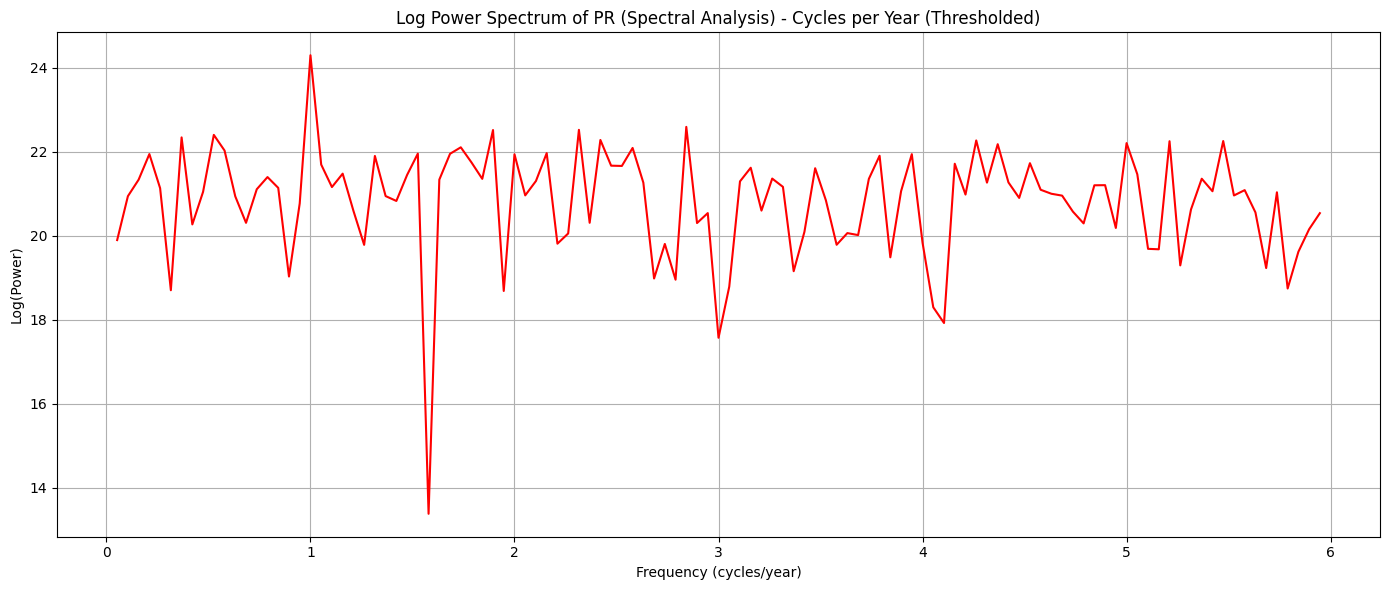

In [5]:
# Analyze any bioclimatic variable with thresholding for the first frequency (DC component)

plot_spectral_analysis_with_thresholding(
    cube=cube, var_name="pr", threshold_first_freq=True
)  # Precipitation with thresholding

# plot_spectral_analysis_with_thresholding(
#     cube, "tas", threshold_first_freq=True
# )  # Mean Temperature with thresholding

# plot_spectral_analysis_with_thresholding(
#     cube, "tasmin", threshold_first_freq=True
# )  # Min Temperature with thresholding

# plot_spectral_analysis_with_thresholding(
#     cube, "tasmax", threshold_first_freq=True
# )  # Max Temperature with thresholding

In [6]:
def find_top_important_frequencies(
    cube: np.ndarray, var_name: str, threshold_first_freq: bool = True, top_n: int = 5
):
    """
    Identify and return the top N most important frequencies based on the power spectrum.
    """
    if var_name not in BIO_VARS:
        raise ValueError(f"Unknown variable: {var_name}")

    var_index = BIO_VARS.index(var_name)
    data = cube[:, :, var_index]  # Shape: (n_years, n_months)

    # Flatten the data to make it a 1D time series across months (for all years)
    flattened_data = data.flatten()

    # Perform FFT
    n = len(flattened_data)
    freqs = fftfreq(n, d=1)  # Frequency axis for FFT (in cycles per month)
    fft_values = fft(flattened_data)  # FFT values

    # Convert frequency from cycles per month to cycles per year
    freqs_per_year = freqs * 12  # Scaling factor: 12 months in a year

    # Power spectrum (magnitude of the FFT)
    power_spectrum = np.abs(fft_values) ** 2

    # Threshold the first frequency (DC component) if specified
    if threshold_first_freq:
        power_spectrum[0] = 0  # Set DC component (frequency 0) to zero

    # Identify the top N frequencies based on power
    sorted_indices = np.argsort(power_spectrum[: n // 2])  # Sort indices based on power
    top_n_indices = sorted_indices[-top_n:][
        ::-1
    ]  # Get the indices of the top N frequencies, sorted descending

    # Get the corresponding frequencies and their power values
    top_frequencies = freqs_per_year[top_n_indices]
    top_powers = power_spectrum[top_n_indices]

    # Return the top N frequencies and their power values
    return top_frequencies, top_powers

In [7]:
# Find the top 5 most important frequencies for the "pr" (precipitation) variable
top_frequencies, top_powers = find_top_important_frequencies(cube, "pr", top_n=5)

# Print the top 5 frequencies and their corresponding power values
for i, (freq, power) in enumerate(zip(top_frequencies, top_powers)):
    print(f"Rank {i + 1}: Frequency = {freq:.4f} cycles/year, Power = {power:.4e}")

Rank 1: Frequency = 1.0000 cycles/year, Power = 3.5691e+10
Rank 2: Frequency = 2.8421 cycles/year, Power = 6.4915e+09
Rank 3: Frequency = 2.3158 cycles/year, Power = 6.0497e+09
Rank 4: Frequency = 1.8947 cycles/year, Power = 6.0204e+09
Rank 5: Frequency = 0.5263 cycles/year, Power = 5.3649e+09


In [8]:
def find_top_periodicities(cube: np.ndarray, var_name: str, top_n: int = 5):
    var_index = BIO_VARS.index(var_name)
    data = cube[:, :, var_index].flatten()

    fft_values = fft(data)
    power = np.abs(fft_values) ** 2
    n = len(data)
    freqs = fftfreq(n, d=1 / 12)  # Monthly series → cycles/year

    # Filter positive frequencies (one-sided spectrum)
    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    power = power[pos_mask]

    # Compute periods in months
    periods = 1 / freqs * 12  # now in months

    # Get top periods
    top_indices = np.argsort(power)[-top_n:][::-1]
    top_periods = periods[top_indices]
    top_powers = power[top_indices]

    return top_periods, top_powers

In [20]:
periods, powers = find_top_periodicities(cube=cube, var_name="tas", top_n=5)

for i, (p, pw) in enumerate(zip(periods, powers)):
    print(f"{i + 1}: Period = {p:.1f} months, Power = {pw:.2e}")

1: Period = 12.0 months, Power = 8.28e+07
2: Period = 28.5 months, Power = 8.38e+05
3: Period = 9.5 months, Power = 4.52e+05
4: Period = 114.0 months, Power = 3.12e+05
5: Period = 13.4 months, Power = 2.59e+05


In [ ]:
import numpy as np


def periodic_rbf(t, c, gamma=1.0, period=12.0):
    # Compute shortest distance on a circle of given period
    dist = np.minimum(np.abs(t - c), period - np.abs(t - c))
    return np.exp(-gamma * dist**2)


def encode_with_multiple_periodic_rbfs(
    t: np.ndarray, periods: list[float], k: int = 6, gamma: float = 2.0
):
    """
    Encode time using RBFs across multiple discovered periods.

    Args:
        t: time vector (e.g., np.arange(228))
        periods: list of discovered periods (e.g., [12, 4.2, 5.2, 6.3, 22.8])
        k: number of RBF centers per period
        gamma: RBF sharpness parameter

    Returns:
        ndarray of shape (len(t), k * len(periods))
    """
    embeddings = []
    for period in periods:
        centers = np.linspace(0, period, k, endpoint=False)
        emb = np.stack(
            [periodic_rbf(t % period, c, gamma, period) for c in centers], axis=1
        )
        embeddings.append(emb)
    return np.concatenate(embeddings, axis=1)

In [21]:
# Your time vector (monthly index over 19 years)
t = np.arange(228)

# Periods discovered from spectral analysis
periods = [12.0, 4.2, 5.2, 6.3, 22.8]

# Create embedding
rbf_embedding = encode_with_multiple_periodic_rbfs(t=t, periods=periods, k=6, gamma=2.0)

# Shape will be (228, 30) if k=6 and 5 periods
print(rbf_embedding.shape)

(228, 30)


## Prepare custom dataset loader

We have to sloightly update the Dataset to provide the relevant data in the
appropriate format.

In [13]:
class TrainDataset(Dataset):
    def __init__(self, data_dir, metadata, subset, transform=None) -> None:
        self.subset = subset

        self.transform = transform

        self.data_dir = data_dir

        self.metadata = metadata

        self.metadata = self.metadata.dropna(subset="speciesId").reset_index(drop=True)

        self.metadata["speciesId"] = self.metadata["speciesId"].astype(int)

        self.label_dict = (
            self.metadata.groupby("surveyId")["speciesId"].apply(list).to_dict()
        )

        self.metadata = self.metadata.drop_duplicates(subset="surveyId").reset_index(
            drop=True
        )

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        survey_id = self.metadata.surveyId[idx]

        sample = torch.load(
            os.path.join(
                self.data_dir,
                f"GLC25-PA-{self.subset}-bioclimatic_monthly_{survey_id}_cube.pt",
            ),
            weights_only=True,
        )

        species_ids = self.label_dict.get(
            survey_id, []
        )  # Get list of species IDs for the survey ID

        label = torch.zeros(num_classes)

        for species_id in species_ids:
            label_id = species_id
            label[label_id] = (
                1  # Set the corresponding class index to 1 for each species
            )

        # Ensure the sample is in the correct format for the transform
        if isinstance(sample, torch.Tensor):
            sample = sample.permute(
                1, 2, 0
            )  # Change tensor shape from (C, H, W) to (H, W, C)
            sample = sample.numpy()

        if self.transform:
            sample = self.transform(sample)

        return sample, label, survey_id


class TestDataset(TrainDataset):
    def __init__(self, data_dir, metadata, subset, transform=None):
        self.subset = subset

        self.transform = transform

        self.data_dir = data_dir

        self.metadata = metadata

    def __getitem__(self, idx):
        survey_id = self.metadata.surveyId[idx]

        sample = torch.load(
            os.path.join(
                self.data_dir,
                f"GLC25-PA-{self.subset}-bioclimatic_monthly_{survey_id}_cube.pt",
            ),
            weights_only=True,
        )

        if isinstance(sample, torch.Tensor):
            sample = sample.permute(
                1, 2, 0
            )  # Change tensor shape from (C, H, W) to (H, W, C)
            sample = sample.numpy()

        if self.transform:
            sample = self.transform(sample)

        return sample, survey_id

### Load metadata and prepare data loaders

In [14]:
# Dataset and DataLoader
batch_size = 64

transform = transforms.Compose(transforms=[transforms.ToTensor()])

# Load Training metadata

train_data_path = "../geolifeclef-2025/BioclimTimeSeries/cubes/PA-train"

train_metadata_path = "../geolifeclef-2025/GLC25_PA_metadata_train.csv"

train_metadata = pd.read_csv(filepath_or_buffer=train_metadata_path)

train_dataset = TrainDataset(
    data_dir=train_data_path,
    metadata=train_metadata,
    subset="train",
    transform=transform,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# Load Test metadata

test_data_path = "../geolifeclef-2025/BioclimTimeSeries/cubes/PA-test"

test_metadata_path = "../geolifeclef-2025/GLC25_PA_metadata_test.csv"

test_metadata = pd.read_csv(filepath_or_buffer=test_metadata_path)

test_dataset = TestDataset(
    data_dir=test_data_path, metadata=test_metadata, subset="test", transform=transform
)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

## Define and initialize the ModifiedResNet18 model

To utilize the bioclimatic cubes, which have a shape of [4,19,12] (RASTER-TYPE,
YEAR, and MONTH), some minor adjustments must be made to the vanilla ResNet-18.
It's important to note that this is just one method for ensuring compatibility
with the unusual tensor shape, and experimentation is encouraged.

In [15]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet18, self).__init__()

        self.norm_input = nn.LayerNorm(normalized_shape=[4, 19, 12])

        self.resnet18 = models.resnet18(weights=None)

        # We have to modify the first convolutional layer to accept 4 channels instead of 3
        self.resnet18.conv1 = nn.Conv2d(
            in_channels=4,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )

        self.resnet18.maxpool = nn.Identity()

        self.ln = nn.LayerNorm(normalized_shape=1000)

        self.fc1 = nn.Linear(in_features=1000, out_features=2056)

        self.fc2 = nn.Linear(in_features=2056, out_features=num_classes)

    def forward(self, x):
        x = self.norm_input(x)
        x = self.resnet18(x)
        x = self.ln(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [16]:
def set_seed(seed) -> None:
    # Set seed for Python's built-in random number generator
    torch.manual_seed(seed=seed)

    # Set seed for numpy
    np.random.seed(seed=seed)

    # Set seed for CUDA if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed=seed)

        # Set cuDNN's random number generator seed for deterministic behavior

        torch.backends.cudnn.deterministic = True

        torch.backends.cudnn.benchmark = False


set_seed(seed=69)

In [17]:
# Check if cuda is available
device = torch.device(device="cpu")

if torch.cuda.is_available():
    device = torch.device(device="cuda")
    print("DEVICE = CUDA")

num_classes = 11255  # Number of all unique classes within the PO and PA data.

model = ModifiedResNet18(num_classes=num_classes).to(device=device)

## Training Loop

Nothing special, just a standard Pytorch training loop.

In [18]:
# Hyperparameters;
learning_rate = 0.0002
num_epochs = 20
positive_weigh_factor = 1.0
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=25, verbose=True);

TypeError: CosineAnnealingLR.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
print(f"Training for {num_epochs} epochs started.")

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (data, targets, _) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        pos_weight = (
            targets * positive_weigh_factor
        )  # All positive weights are equal to 10

        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

        if batch_idx % 278 == 0:
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}"
            )

    scheduler.step()

    print("Scheduler:", scheduler.state_dict())

# Save the trained model
model.eval()

torch.save(model.state_dict(), "resnet18-with-bioclimatic-cubes.pth")

## Test Loop

Again, nothing special, just a standard inference.

In [ ]:
with torch.no_grad():
    all_predictions = []

    surveys = []

    top_k_indices = None

    for data, surveyID in tqdm.tqdm(test_loader, total=len(test_loader)):
        data = data.to(device)

        outputs = model(data)
        predictions = torch.sigmoid(outputs).cpu().numpy()

        # Sellect top-25 values as predictions

        top_25 = np.argsort(-predictions, axis=1)[:, :25]

        if top_k_indices is None:
            top_k_indices = top_25
        else:
            top_k_indices = np.concatenate((top_k_indices, top_25), axis=0)

        surveys.extend(surveyID.cpu().numpy())

## Save prediction file! 🎉🥳🙌🤗

In [ ]:
data_concatenated = [" ".join(map(str, row)) for row in top_k_indices]

pd.DataFrame(
    data={
        "surveyId": surveys,
        "predictions": data_concatenated,
    }
).to_csv(path_or_buf="submission.csv", index=False)